In [1]:
from __future__ import print_function
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime

In [2]:
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2021-02-06 15:17:54.397831


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.RandomErasing(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [6]:

class QuizNet(nn.Module):
    def __init__(self):
        super(QuizNet, self).__init__()
        
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        self.intermediate1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(1, 1), padding=0 , bias=False),
        )
        
        self.intermediate2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0 , bias=False),
        )
        
        self.pool = nn.MaxPool2d(2, 2)

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2, dilation=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)            
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.intermediate3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), padding=0 , bias=False),
        )
        
        self.intermediate4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0 , bias=False),
        )        

        
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) 

    def forward(self, x1):
        x2 = self.convblock1(x1)
        x1 = self.intermediate1(x1)
        x3 = self.convblock2(x1+x2)
        x4 = self.pool(self.intermediate2(x1)+self.intermediate2(x2)+x3)
        x5 = self.convblock3(x4)        
        x6 = self.convblock3(x4+x5)
        x7 = self.convblock3(x4+x5+x6)
        x8 = self.pool(x5+x6+x7)
        x9 = self.convblock4(x8)
        #x8 = self.intermediate3(x8)  
        x10 = self.convblock4(x8+x9)
        x11 = self.convblock4(x8+x9+x10)        
        x = self.gap(x11)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = QuizNet().to(device)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
              ReLU-2         [-1, 32, 128, 128]               0
       BatchNorm2d-3         [-1, 32, 128, 128]              64
            Conv2d-4         [-1, 32, 128, 128]              96
            Conv2d-5         [-1, 64, 128, 128]          18,432
              ReLU-6         [-1, 64, 128, 128]               0
       BatchNorm2d-7         [-1, 64, 128, 128]             128
            Conv2d-8         [-1, 64, 128, 128]           2,048
            Conv2d-9         [-1, 64, 128, 128]           2,048
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,864
             ReLU-12           [-1, 64, 64, 64]               0
      BatchNorm2d-13           [-1, 64, 64, 64]             128
           Conv2d-14           [-1, 64,

In [8]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=train_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=test_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/cifar-10-python.tar.gz to ../data


In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  QuizNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


loss=1.4331601858139038 batch_id=390 Accuracy=42.20: 100%|██████████| 391/391 [00:59<00:00,  6.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3209, Accuracy: 5148/10000 (51%)

EPOCH: 1


loss=1.1417895555496216 batch_id=390 Accuracy=56.45: 100%|██████████| 391/391 [01:00<00:00,  6.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1090, Accuracy: 6088/10000 (61%)

EPOCH: 2


loss=0.9279807209968567 batch_id=390 Accuracy=62.56: 100%|██████████| 391/391 [00:59<00:00,  6.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9229, Accuracy: 6737/10000 (67%)

EPOCH: 3


loss=0.8127015233039856 batch_id=390 Accuracy=65.95: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8820, Accuracy: 6919/10000 (69%)

EPOCH: 4


loss=0.9011063575744629 batch_id=390 Accuracy=68.17: 100%|██████████| 391/391 [00:59<00:00,  6.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8108, Accuracy: 7201/10000 (72%)

EPOCH: 5


loss=0.8252071142196655 batch_id=390 Accuracy=70.35: 100%|██████████| 391/391 [00:59<00:00,  6.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8068, Accuracy: 7218/10000 (72%)

EPOCH: 6


loss=0.9023130536079407 batch_id=390 Accuracy=71.74: 100%|██████████| 391/391 [00:59<00:00,  6.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7222, Accuracy: 7507/10000 (75%)

EPOCH: 7


loss=0.8915308117866516 batch_id=390 Accuracy=72.87: 100%|██████████| 391/391 [00:59<00:00,  6.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7238, Accuracy: 7506/10000 (75%)

EPOCH: 8


loss=0.8428115844726562 batch_id=390 Accuracy=73.88: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6997, Accuracy: 7601/10000 (76%)

EPOCH: 9


loss=0.6138681173324585 batch_id=390 Accuracy=74.56: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6753, Accuracy: 7641/10000 (76%)

EPOCH: 10


loss=0.5787930488586426 batch_id=390 Accuracy=75.38: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6678, Accuracy: 7722/10000 (77%)

EPOCH: 11


loss=0.6075004935264587 batch_id=390 Accuracy=75.71: 100%|██████████| 391/391 [01:00<00:00,  6.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6505, Accuracy: 7792/10000 (78%)

EPOCH: 12


loss=0.7655700445175171 batch_id=390 Accuracy=76.54: 100%|██████████| 391/391 [01:00<00:00,  6.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6818, Accuracy: 7692/10000 (77%)

EPOCH: 13


loss=0.6759411692619324 batch_id=390 Accuracy=77.14: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6242, Accuracy: 7868/10000 (79%)

EPOCH: 14


loss=0.8537168502807617 batch_id=390 Accuracy=77.88: 100%|██████████| 391/391 [00:59<00:00,  6.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6154, Accuracy: 7908/10000 (79%)

EPOCH: 15


loss=0.5858637094497681 batch_id=390 Accuracy=78.09: 100%|██████████| 391/391 [00:59<00:00,  6.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6492, Accuracy: 7828/10000 (78%)

EPOCH: 16


loss=0.6289273500442505 batch_id=390 Accuracy=78.53: 100%|██████████| 391/391 [01:00<00:00,  6.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6455, Accuracy: 7852/10000 (79%)

EPOCH: 17


loss=0.5986519455909729 batch_id=390 Accuracy=79.10: 100%|██████████| 391/391 [00:59<00:00,  6.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6246, Accuracy: 7929/10000 (79%)

EPOCH: 18


loss=0.4755161702632904 batch_id=390 Accuracy=79.23: 100%|██████████| 391/391 [00:59<00:00,  6.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6139, Accuracy: 7961/10000 (80%)

EPOCH: 19


loss=0.6345616579055786 batch_id=390 Accuracy=79.63: 100%|██████████| 391/391 [01:00<00:00,  6.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6092, Accuracy: 7993/10000 (80%)

EPOCH: 20


loss=0.4720875322818756 batch_id=390 Accuracy=79.92: 100%|██████████| 391/391 [00:59<00:00,  6.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6303, Accuracy: 7912/10000 (79%)

EPOCH: 21


loss=0.5069018602371216 batch_id=390 Accuracy=80.26: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6069, Accuracy: 8022/10000 (80%)

EPOCH: 22


loss=0.7028641700744629 batch_id=390 Accuracy=80.36: 100%|██████████| 391/391 [01:00<00:00,  6.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6277, Accuracy: 7954/10000 (80%)

EPOCH: 23


loss=0.3809505105018616 batch_id=390 Accuracy=80.69: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6286, Accuracy: 7975/10000 (80%)

EPOCH: 24


loss=0.32387909293174744 batch_id=390 Accuracy=80.86: 100%|██████████| 391/391 [01:00<00:00,  6.51it/s]



Test set: Average loss: 0.5999, Accuracy: 8026/10000 (80%)



Text(0.5, 1.0, 'Test Accuracy')

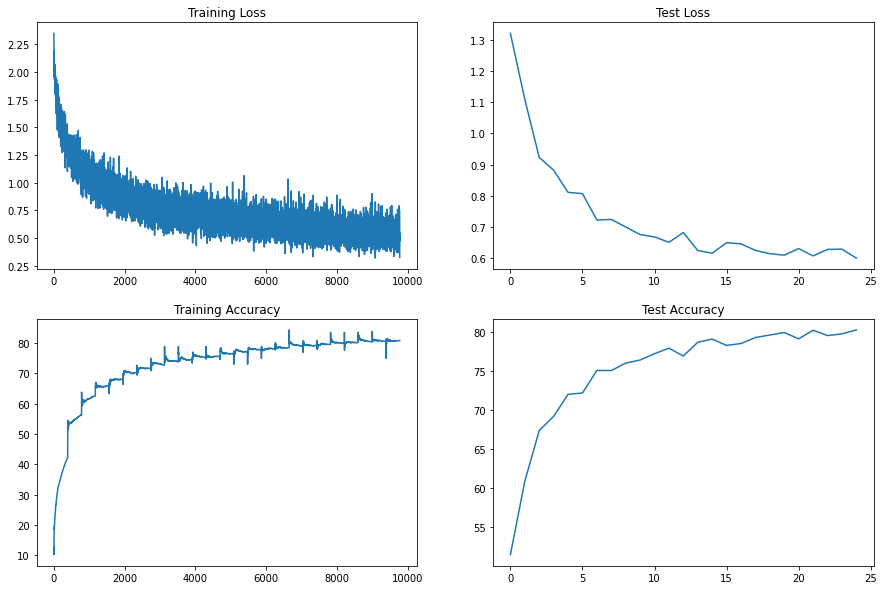

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")